# Reconstruction from interpolated values with known locations

In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

In [2]:
import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.interpolate import *
from src.algorithm import conjugate_gradient
import jax
from src.utils import mip_z

Create the grids and the volume

In [3]:
nx = 5

x_freq = jnp.fft.fftfreq(nx, 1/nx)
y_freq = x_freq
z_freq = x_freq

X, Y, Z = jnp.meshgrid(x_freq, y_freq, z_freq)


x_grid = np.array([x_freq[1], len(x_freq)])
y_grid = np.array([y_freq[1], len(y_freq)])
z_grid = np.array([z_freq[1], len(z_freq)])

vol = jnp.array(np.random.randn(nx,nx,nx)) + jnp.array(np.random.randn(nx,nx,nx))*1j + 100+80j

all_coords = jnp.array([X.ravel(), Y.ravel(), Z.ravel()])

Generate points on or off the grid

In [4]:
N = 2000

# The points will be on the grid between low and high. 
# Going outside the range by half, to ensure wrap-around works well.
low = -3*nx
high = 3*nx

# Actually not going outside the range for now
#low = -nx/2
#high = nx/2

#pts = jnp.array(np.random.randint(low, high, size = (3,N))).astype(jnp.float64)

# Points between grid points
pts = 3*nx * np.random.randn(3,N)


In [6]:
@jax.jit
def interpolate_fun(vol):
    return interpolate(pts, x_grid, vol, "tri")

The interpolated values, i.e. the data. When the points above are on the grid, this is the volume.

In [7]:
data = interpolate_fun(vol)

In [8]:
@jax.jit
def loss_fun(v):
    err = interpolate_fun(v) - data
    return 1/(2*len(data))*jnp.sum(jnp.real(jnp.conj(err)*err))

@jax.jit
def loss_fun_grad(v):
    return jax.grad(loss_fun)(v)

In [9]:
loss_fun(vol)

DeviceArray(0., dtype=float64)

In [10]:
loss_fun_grad(vol).shape

(5, 5, 5)

### Solve the inverse problem

#### SGD

In [11]:
v0 = jnp.array(np.random.randn(nx,nx,nx)) + jnp.array(np.random.randn(nx,nx,nx))*1j
#v0 = vol + 0.1*np.random.randn(nx,nx,nx)

vk = v0
N_iter = 2000
alpha = 100
for k in range(N_iter):
    vk = vk - alpha * jnp.conj(loss_fun_grad(vk))
    
    if jnp.mod(k,100) == 0:
        loss = loss_fun(vk)
        print("iter ", k, ", loss = ", loss)

err = jnp.max(jnp.abs(vk-vol))
print("err =", err)

iter  0 , loss =  321.88141350945983
iter  100 , loss =  5.059791510457054e-05
iter  200 , loss =  2.9424938846405472e-08
iter  300 , loss =  2.5733754381345417e-11
iter  400 , loss =  2.390334951302091e-14
iter  500 , loss =  2.2368827771761783e-17
iter  600 , loss =  2.0953119851708257e-20
iter  700 , loss =  1.962716587955743e-23
iter  800 , loss =  1.9115525994021756e-26
iter  900 , loss =  7.079300872325778e-28
iter  1000 , loss =  7.079300872325778e-28
iter  1100 , loss =  7.079300872325778e-28
iter  1200 , loss =  7.079300872325778e-28
iter  1300 , loss =  7.079300872325778e-28
iter  1400 , loss =  7.079300872325778e-28
iter  1500 , loss =  7.079300872325778e-28
iter  1600 , loss =  7.079300872325778e-28
iter  1700 , loss =  7.079300872325778e-28
iter  1800 , loss =  7.079300872325778e-28
iter  1900 , loss =  7.079300872325778e-28
err = 4.622352198365034e-13


In [12]:
jnp.max(jnp.abs(vk-vol))

DeviceArray(4.6223522e-13, dtype=float64)

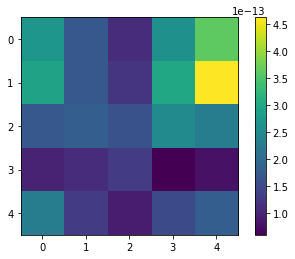

In [13]:
mip_z(jnp.abs(vk-vol));plt.colorbar()

#### CG

In [14]:
v0 = jnp.array(np.random.randn(nx,nx,nx)) + jnp.array(np.random.randn(nx,nx,nx))*1j
zero = jnp.zeros(vol.shape)*1j
Ab = -jnp.conj(loss_fun_grad(zero))
AA = lambda a : jnp.conj(loss_fun_grad(a)) + Ab


vcg, max_iter = conjugate_gradient(AA, Ab, v0, 50, verbose = True)
err = jnp.max(jnp.abs(vcg-vol))
print("err =", err)

Iter 0 ||r|| = 0.7280502232108537
Iter 1 ||r|| = 0.19621791561433521
Iter 2 ||r|| = 0.09295452883022128
Iter 3 ||r|| = 0.051239755421181817
Iter 4 ||r|| = 0.0294807169893329
Iter 5 ||r|| = 0.01766750655934522
Iter 6 ||r|| = 0.009997181183237664
Iter 7 ||r|| = 0.0058459307578549715
Iter 8 ||r|| = 0.004212360095789887
Iter 9 ||r|| = 0.0028755625124367596
Iter 10 ||r|| = 0.0019289907652858393
Iter 11 ||r|| = 0.001205278063038539
Iter 12 ||r|| = 0.0007225302448942171
Iter 13 ||r|| = 0.00041141536708506616
Iter 14 ||r|| = 0.00028934967752664806
Iter 15 ||r|| = 0.00017331968618554766
Iter 16 ||r|| = 0.0001351974420287874
Iter 17 ||r|| = 8.734264348118462e-05
Iter 18 ||r|| = 5.217156425385651e-05
Iter 19 ||r|| = 3.0443434332385483e-05
Iter 20 ||r|| = 1.719002742112916e-05
Iter 21 ||r|| = 9.35045514154698e-06
Iter 22 ||r|| = 4.944267896485961e-06
Iter 23 ||r|| = 2.8102075863731913e-06
Iter 24 ||r|| = 1.5017111885181113e-06
Iter 25 ||r|| = 7.042593128768324e-07
Iter 26 ||r|| = 4.604617194540559

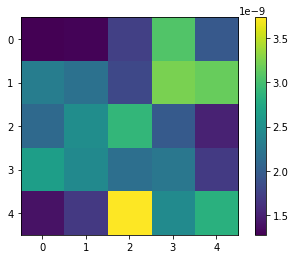

In [15]:
mip_z(jnp.abs(vcg-vol));plt.colorbar()